## **Resolução do desafio técnico da Foco**
O desafio consiste em prever os resultados para os próximos 12 meses (jan/2025 a dez/2025) com base nos dados históricos dos contratos realizados entre jan/2023 e dez/2024.

Deve-se utilizar a base histórica fictícia fornecida para projetar os seguintes indicadores por loja e por mês:
1. Diárias Locadas
2. Diária Média

**Sobre a base de dados:**\
A base fornecida contém registros simulados de contratos de locação com as seguintes colunas:

- id_contrato
- data_inicio_locacao
- duracao_locacao (dias)
- id_loja
- dias_antecedencia (entre reserva e início locação)
- diaria_media
- valor_total_locacao (diaria_media x duração_locacao)

---

**Como executar este notebook:**

 Clone o repositório do desafio. https://github.com/getrolucas/desafio-tecnico-foco.git
- Usando `uv` [Recomendado]: Se não tiver, instale `uv` para gerenciar o ambiente virtual. Disponível em: (https://docs.astral.sh/uv/getting-started/installation/). Na pasta do projeto, execute o seguinte comando no cmd: `uv sync`.
- Usando `pip`: Execute os seguintes comandos: `python -m venv` para criar um ambiente virtual. Em seguida `pip install -r requirements.txt` para instalar os pacotes.


### **Preparação do Notebook**

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.ts_plots import plot_time_series # módulo local, ver repositório github

import warnings
warnings.filterwarnings("ignore")

from functools import lru_cache
import pandas as pd
import numpy as np

import holidays
from holidays.countries import BR

from scipy.stats import ttest_ind
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean
from mlforecast.target_transforms import LocalStandardScaler
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%reload_ext autoreload
%autoreload 2 

### **Análise Exploratória dos Dados**

In [2]:
df = pd.read_excel(
    r'..\data\Desafio Inteligência (Cientista de Dados) V.2.xlsx',
    sheet_name='base_locacoes',
    usecols=range(7),
    parse_dates=['data_inicio_locacao']
)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103398 entries, 0 to 103397
Data columns (total 7 columns):
 #   Column                                                Non-Null Count   Dtype         
---  ------                                                --------------   -----         
 0   id_contrato                                           103398 non-null  object        
 1   data_inicio_locacao                                   103398 non-null  datetime64[ns]
 2   duracao_locacao (dias)                                103398 non-null  int64         
 3   id_loja                                               103398 non-null  object        
 4   dias_antecedencia (entre reserva e início locação)    103398 non-null  int64         
 5   diaria_media                                          103398 non-null  int64         
 6   valor_total_locacao (diaria_media x duração_locacao)  103398 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 5.5+ MB


,id_contrato,data_inicio_locacao,duracao_locacao (dias),id_loja,dias_antecedencia (entre reserva e início locação),diaria_media,valor_total_locacao (diaria_media x duração_locacao)
0,LojaC1000000,2024-09-21,4,LojaC,59,98,95
1,LojaC1000001,2024-10-14,5,LojaC,9,111,95
2,LojaC1000002,2024-10-13,2,LojaC,56,148,1
3,LojaC1000003,2024-10-26,3,LojaC,15,130,88
4,LojaC1000004,2024-11-21,4,LojaC,18,169,41


#### **_Analisando algumas estatísticas descritivas da base de dados._**

In [3]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
data_inicio_locacao,103398,2024-06-28 13:18:19.448732160,2023-10-05 00:00:00,2024-03-22 00:00:00,2024-06-29 00:00:00,2024-10-04 00:00:00,2024-12-31 00:00:00,NaN
duracao_locacao (dias),103398.00,6.20,1.00,3.00,5.00,8.00,360.00,5.14
dias_antecedencia (entre reserva e início locação),103398.00,21.92,0.00,1.00,7.00,27.00,387.00,36.36
diaria_media,103398.00,130.33,-73.00,92.00,113.00,151.00,1588.00,66.95
valor_total_locacao (diaria_media x duração_locacao),103398.00,80.01,-175.00,16.00,47.00,76.00,12875.00,226.20


**Nota:** O arquivo de orientações não trouxe um metadados abrangente sobre as variáveis, faltando informações de como são construídas as variáveis, quais as regras de negócio aplicadas etc. Isso facilitaria o entendimento dos dados e identificação de possíveis outliers, erros de registro entre outras informações que dariam suporte à modelagem e preprocessamento dos dados. \
Devido a isto, usaremos algumas suposições como base para analisar as estatísticas descritivas. 
- **diaria_media**: Supõe-se que seja um dado de faturamento/valor monetário. Considerando isso, é estranho que haja na base de dados valores negativos, que é o caso do valor mínimo em _diaria_media_ e _valor_total_locacao_. Um próximo passo será identificar quantos registros negativos existem na base e qual o impacto deles na série. Caso hajam mais evidências de que o dado não deveria fazer parte do conjunto de amostra, podemos usar alguma técnica de interpolação ou substituição do valor em questão.
- **data_inicio_locacao**: A data mínima é 05 de Outubro de 2023, enquanto a máxima é 31 de Dezembro de 2024, totalizando 15 meses de observações. Período curto para decomposição sazonal da série, pois não conclui o mínimo de 2 ciclos sazonais completos. Sendo assim, poderemos investigar a existência de tendência, mas não de padrão sazonal mensal.

Vamos analisar algumas estatísticas das variáveis objetivo por loja:

In [4]:
df.groupby('id_loja')[['diaria_media', 'duracao_locacao (dias)']].describe()

diaria_media                                                   \
               count   mean   std    min    25%    50%    75%     max   
id_loja                                                                 
LojaA       53601.00 123.03 58.20 -61.00  92.00 108.00 139.00 1222.00   
LojaB       26142.00 123.81 69.86 -25.00  84.00 106.00 144.00 1553.00   
LojaC       23655.00 154.09 76.10 -73.00 110.00 133.00 178.00 1588.00   

        duracao_locacao (dias)                                       
                         count mean  std  min  25%  50%  75%    max  
id_loja                                                              
LojaA                 53601.00 6.73 4.94 1.00 4.00 6.00 8.00  90.00  
LojaB                 26142.00 6.59 5.02 1.00 4.00 6.00 8.00 178.00  
LojaC                 23655.00 4.56 5.36 1.00 2.00 3.00 5.00 360.00

Verificando a porcentagem de valores negativos na coluna _diaria_media_.

In [5]:
np.divide(
    df[df['diaria_media'] < 0].groupby('id_loja')['diaria_media'].count(),
    df[df['diaria_media'] >= 0].groupby('id_loja')['diaria_media'].count()
) * 100

id_loja
LojaA   0.02
LojaB   0.01
LojaC   0.01
Name: diaria_media, dtype: float64

A quantidade de valores negativos representa menos de 1% do total da amostra, o que não é significativo. Nesse caso, poderíamos optar por remover os dados ou usar algum método de substituição que não afetaria o resultado e implicações da análise. \
Em todo caso, o melhor caminho é investigar mais profudamente o que levou ao registro errado dos preços médios e buscar substituir pelo valor factual, no entanto, como não é possível, iremos substituir pela média de cada _id_loja_ no mês onde ocorreram os registros errados.

In [6]:
df['ano_mes'] = df['data_inicio_locacao'].dt.to_period('M')

medias = (
    df.loc[df['diaria_media'] >= 0]
      .groupby(['id_loja', 'ano_mes'], as_index=False)
      .agg(
        media_sem_negativo = pd.NamedAgg('diaria_media', 'mean')
      )
)

df = df.merge(medias, on=['id_loja', 'ano_mes'], how='left')
df.loc[df['diaria_media'] < 0, 'diaria_media'] = df.loc[df['diaria_media'] < 0, 'media_sem_negativo']
df.drop(columns=['media_sem_negativo', 'ano_mes'], inplace=True)

In [7]:
df.groupby('id_loja')['diaria_media'].describe()

,count,mean,std,min,25%,50%,75%,max
id_loja,,,,,,,,
LojaA,53601.00,123.06,58.16,0.00,92.00,108.00,139.00,1222.00
LojaB,26142.00,123.82,69.84,0.00,84.00,106.00,144.00,1553.00
LojaC,23655.00,154.11,76.07,0.00,110.00,133.00,178.00,1588.00


#### **_Análise de Feriados._**
Será realizada análise de feriados uma vez que o tipo de negócio pode sofrer influência de feriados que elevam a procura por serviços relacionados a viagens, que é o caso de aluguéis de carros. \
Para análise, será utilizada a biblioteca `holidays`, que traz a lista de todos os feriados nacionais.

Será ainda realizado um teste t para verificar a diferença de médias entre os preços médios das diárias locadas nesses dias, que poderia indicar uma estratégia específica para períodos de feriado e portanto podemos inserir como variável regressora para prever o indicador. Para avaliar o resultado, será utilizado o limiar de 99% de confiança para garantir máxima confiabilidade.

In [8]:
# ferificando os feriados no Brasil com base na biblioteca holidays
for date, name in sorted(BR(years=[2025, 2026]).items()):
    print(date, name)

2025-01-01 Confraternização Universal
2025-04-18 Sexta-feira Santa
2025-04-21 Tiradentes
2025-05-01 Dia do Trabalhador
2025-09-07 Independência do Brasil
2025-10-12 Nossa Senhora Aparecida
2025-11-02 Finados
2025-11-15 Proclamação da República
2025-11-20 Dia Nacional de Zumbi e da Consciência Negra
2025-12-25 Natal
2026-01-01 Confraternização Universal
2026-04-03 Sexta-feira Santa
2026-04-21 Tiradentes
2026-05-01 Dia do Trabalhador
2026-09-07 Independência do Brasil
2026-10-12 Nossa Senhora Aparecida
2026-11-02 Finados
2026-11-15 Proclamação da República
2026-11-20 Dia Nacional de Zumbi e da Consciência Negra
2026-12-25 Natal


In [9]:
@lru_cache(maxsize=512)
def is_holiday(date : pd._libs.tslibs.timestamps.Timestamp) -> int:
    """Indentifica se determinada data é feriado no Brasil.
    
    Args:
        date (pd._libs.tslibs.timestamps.Timestamp): Data a ser verificada.
    Returns:
        int: 1 se for feriado, 0 caso contrário.
    """
    if date in holidays.country_holidays('BR'):
        return 1
    return 0

# aplicando a transformação para identificar feriados e analisar
df['feriado'] = df['data_inicio_locacao'].apply(is_holiday)
df[df['feriado'] == 1].head()

,id_contrato,data_inicio_locacao,duracao_locacao (dias),id_loja,dias_antecedencia (entre reserva e início locação),diaria_media,valor_total_locacao (diaria_media x duração_locacao),feriado
30,LojaC1000030,2024-10-12,5,LojaC,34,120.00,5,1
66,LojaC1000066,2024-09-07,2,LojaC,4,172.00,72,1
79,LojaC1000079,2024-11-02,6,LojaC,0,116.00,23,1
86,LojaC1000086,2024-11-15,1,LojaC,5,264.00,79,1
88,LojaC1000088,2024-11-02,7,LojaC,1,112.00,44,1


In [10]:
df.groupby('feriado')['diaria_media'].describe()

,count,mean,std,min,25%,50%,75%,max
feriado,,,,,,,,
0,100451.00,130.07,66.17,0.00,92.00,113.00,150.00,1588.00
1,2947.00,140.21,88.11,0.00,94.00,118.00,164.50,1363.00


In [11]:
feriado = df[df['feriado'] == 1]['diaria_media']
nao_feriado = df[df['feriado'] == 0]['diaria_media']

# realizando o teste t para diferença de médias
stat, pvalue = ttest_ind(feriado, nao_feriado, equal_var=False, nan_policy='omit')

print(f'Estatística de teste: {stat:.2f}')
print(f'p valor: {pvalue:.4f}')

Estatística de teste: 6.20
p valor: 0.0000


**Nota**: As séries apresentaram diferença significativa de médias a 99% de confiança, observada pelo p-valor < 0.01. Portanto, iremos inserir a informação nos dados de treino e teste para previsão do indicador.

In [12]:
feriado = df[df['feriado'] == 1]['duracao_locacao (dias)']
nao_feriado = df[df['feriado'] == 0]['duracao_locacao (dias)']

# realizando o teste t para diferença de médias
stat, pvalue = ttest_ind(feriado, nao_feriado, equal_var=False, nan_policy='omit')

print(f'Estatística de teste: {stat:.2f}')
print(f'p valor: {pvalue:.4f}')

Estatística de teste: -2.09
p valor: 0.0365


**Nota**: As séries não apresentaram diferença significativa de médias a 99% de confiança, observada pelo p-valor > 0.01. Portanto, para este indicado, não iremos inserir a informação como variável regressora.

#### **_Agrupando as séries para visualização._**

Considerando o problema, que é previsão *mensal* e *por loja*, devemos agregar os as variáveis de modo a transformar a série diária em mensal.
- **data_inicio_locacao**: Índice temporal. Frequência diária. Deve-se transformar a variável que está em frequência diária em mensal para realizar o agrupamento.
- **diaria_media**: Variável objetivo. Previsão do preço da diária média. Para tanto, vamos calcular a média da variável por mês/loja ponderada pela quantidade de diárias, para manter o preço médio mensal correto.
- **duracao_lotacao (dias)**: Variável objetivo. Quantidade de dias locados em cada contrato. Podemos somar por mês/loja e estimar a quantidade demandada.
- **feriados**: Variável explicativa. Será realizada imputação dos valores com base na quantidade de feriados no mês em questão.
___ 
- **dias_antecedencia (entre reserva e início locação)**: Não constam os dados futuros, portanto, seria necessário um processo adicional de inferência e alinhamento com áreas de negócio para entender o comportamento do consumidor para o próximo ano. Por isso, iremos desconsiderar a variável e simplificar a análise.   
- **valor_total_locacao (diaria_media x duração_locacao)**: Embora  combinação entre as variáveis objetivo. Portanto não tem utilidade para fins de predição.

In [13]:
df.loc[:, 'ds'] = df['data_inicio_locacao'] + pd.offsets.MonthBegin(-1)

df['valor_total'] = df['diaria_media'] * df['duracao_locacao (dias)']

df_mensal_temp = (
    df
    .groupby(['ds', 'id_loja'], as_index=False)
    .agg(
        qtd_diarias_locadas = ('duracao_locacao (dias)', 'sum'),
        soma_valor_total = ('valor_total', 'sum')
    )
)

df_mensal = df_mensal_temp.copy()
df_mensal['diaria_media'] = df_mensal['soma_valor_total'] / df_mensal['qtd_diarias_locadas']

df_mensal = df_mensal[['ds', 'id_loja', 'qtd_diarias_locadas', 'diaria_media']]

df_mensal.head()

,ds,id_loja,qtd_diarias_locadas,diaria_media
0,2023-10-01,LojaB,178,67.00
1,2023-11-01,LojaA,342,69.75
2,2023-11-01,LojaB,312,98.85
3,2023-12-01,LojaA,13412,163.06
4,2023-12-01,LojaB,7259,172.02


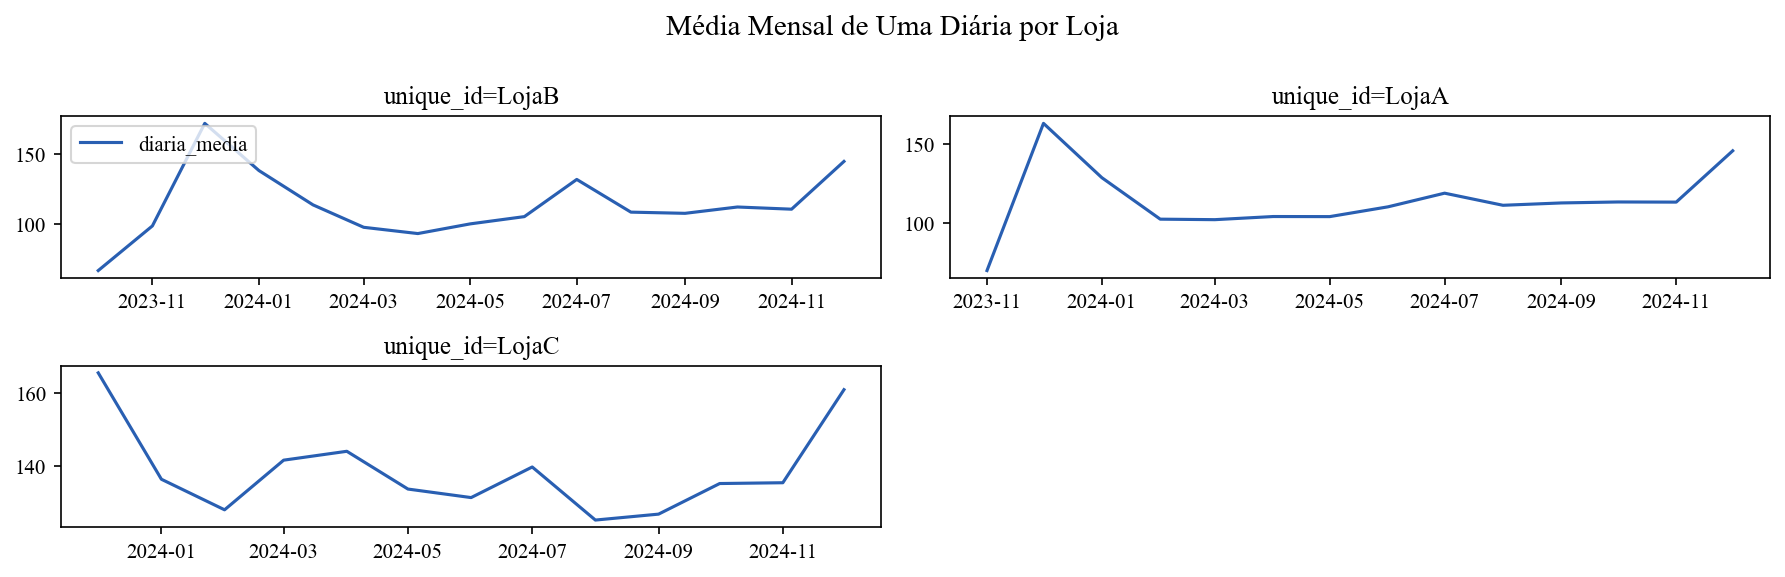

In [14]:
# visualização da série diaria_media
fig = plot_time_series(
    df=df_mensal,
    data_cols=['diaria_media'],
    time_col='ds',
    id_col='id_loja',
    title='Média Mensal de Uma Diária por Loja',
)
fig.show()

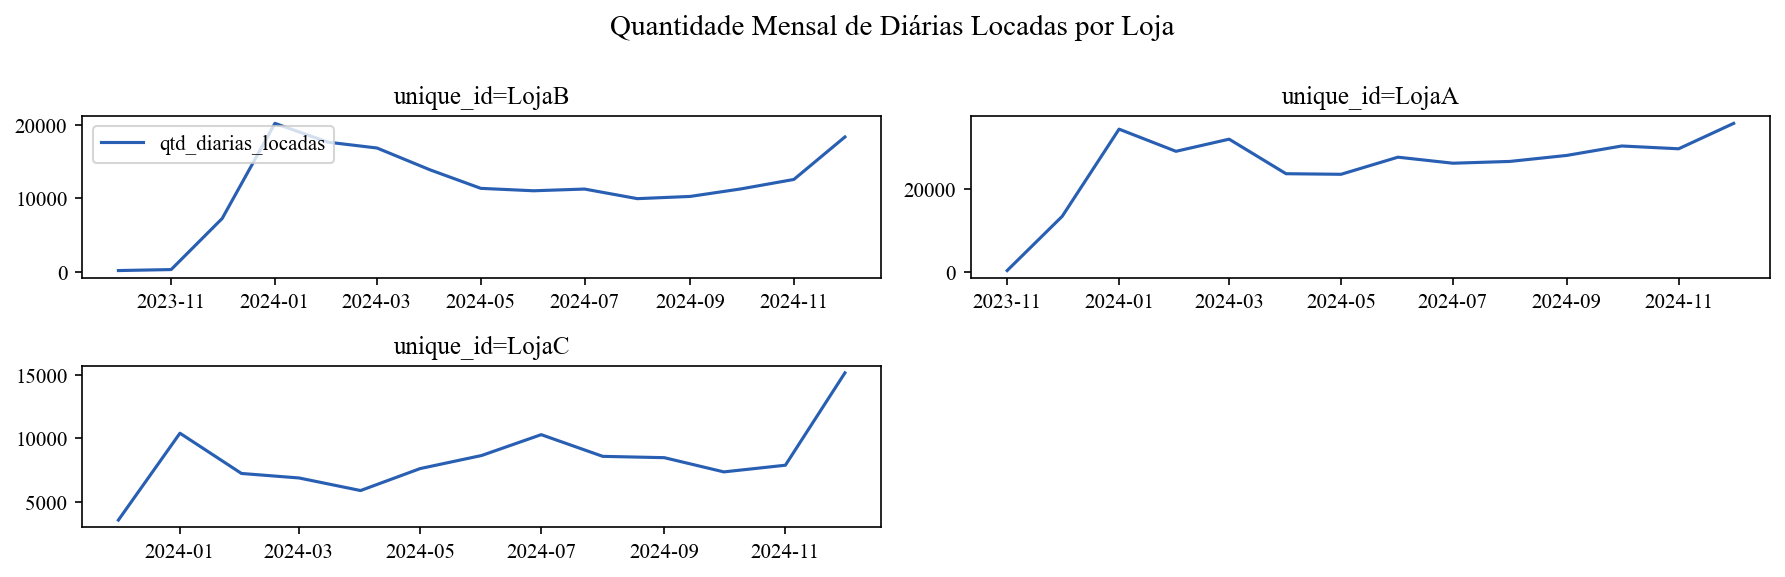

In [15]:
# visualização da série qtd_diarias_locadas
fig = plot_time_series(
    df=df_mensal,
    data_cols=['qtd_diarias_locadas'],
    time_col='ds',
    id_col='id_loja',
    title='Quantidade Mensal de Diárias Locadas por Loja',
)
fig.show()

#### **_Engenharia de Características._**

Iremos construir algumas variáveis para regressão.
- **feriados**: Variável que indica a quantidade de feriados no mês da observação.
- **dummy sazonal**: Variável que indica o mês da observação, utilizada para modelar sazonalidade ou impacto de algum mês em específico na quantidade da variável objetivo.

In [16]:
# construção da variável feriados
def qtd_feriados(date: pd._libs.tslibs.timestamps.Timestamp) -> int:
    """Retorna a quantidade de feriados em um determinado mês.
    
    Args:
        date (pd._libs.tslibs.timestamps.Timestamp): Data a ser verificada.
    
    Returns:
        int: Quantidade de feriados no mês da data.
    """
    br_holidays = holidays.country_holidays('BR', years=[date.year])
    return sum(1 for day in br_holidays if day.month == date.month)


df_mensal['feriados'] = df_mensal['ds'].apply(qtd_feriados)

In [17]:
# construção das dummies sazonais
df_mensal = pd.get_dummies(
    df_mensal.assign(mes = df_mensal.ds.dt.month), 
    columns=['mes'], 
    drop_first=True, 
    prefix='mes', 
    dtype=int
)

#### **_Modelagem._**

Para previsão das séries, iremos realizar previsão com dois modelos, sendo um modelo linear tradicional e um baseado em árvores de regressão.
Será utilizada a biblioteca `Nixtla`, que traz implementações rápidas e robustas, além de algumas facilidades de interpretação dos resultados.

Também iremos construir um dataframe com as datas futuras e reproduriz as mesmas features.

In [18]:
def make_future_dataframe(
        df: pd.DataFrame, periods: int, freq: str = 'MS', unique_id : str = 'id_loja'
    ) -> pd.DataFrame:
    """Cria um DataFrame com datas futuras para previsão.
    
    Args:
        df (pd.DataFrame): DataFrame original com as séries temporais.
        periods (int): Número de períodos futuros a serem criados.
        freq (str, optional): Frequência das datas. Padrão é 'MS' (início do mês).
    
    Returns:
        pd.DataFrame: DataFrame com as datas futuras.
    """
    future_dates = pd.date_range(
        start=df['ds'].max() + pd.offsets.MonthBegin(1),
        periods=periods,
        freq=freq
    )
    
    future_df = pd.DataFrame({
        'ds': np.tile(future_dates, df[unique_id].nunique()),
        'unique_id': np.repeat(df[unique_id].unique(), periods)
    })
    
    return future_df

In [19]:
future_df = make_future_dataframe(df_mensal, periods=12)

# adicionando feature feriados
future_df['feriados'] = future_df.ds.apply(qtd_feriados)

# adicionando dummies sazonais
future_df = pd.get_dummies(
    future_df.assign(mes = future_df.ds.dt.month), 
    columns=['mes'], 
    drop_first=True, 
    prefix='mes', 
    dtype=int
)

Aqui será realizada a instância do modelo.
Para o problema, utilizaremos `LassoCV`, que penaliza as features com baixo poder explicativo e deixa apenas as features com algum impacto estatisticamente significativo na variável objetivo. A utilização do modelo possibilita a avaliação das features com base no $\hat{\beta}$ estimado, trazendo maior explicabilidade comparado a modelos de Machine Learning, que a explicabilidade é com base na redução do erro de cada nó, no caso de modelos baseados em árvore. \
Também utilizaremos o modelo `RandomForest`, que tem alto poder preditivo e é de simples implementação. 

Além das features construídas, serão acrescentadas 1 defasagem como regressor, sugerindo ao modelo que o valor do mês anterior tem poder preditivo sobre o mês atual e a ExpandingMean, que calcula a média do valor objetivo defasado até o tempo $t$, ambas diretamente no pipeline no `mlforecast` da `Nixtla`. 

In [20]:
models = [
    LassoCV(random_state=42, n_jobs=-1),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
]

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1],
    lag_transforms={
        1: [ExpandingMean()],
    },
    target_transforms=[
    ],
)

#### **_Previsão da Diária Média._**

In [21]:
diaria_media_df = (
    df_mensal
    .rename(columns={'id_loja':'unique_id', 'diaria_media':'y'})
    .drop(columns=['qtd_diarias_locadas'])
)
diaria_media_df.head()

,ds,unique_id,y,feriados,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,2023-10-01,LojaB,67.00,1,0,0,0,0,0,0,0,0,1,0,0
1,2023-11-01,LojaA,69.75,2,0,0,0,0,0,0,0,0,0,1,0
2,2023-11-01,LojaB,98.85,2,0,0,0,0,0,0,0,0,0,1,0
3,2023-12-01,LojaA,163.06,1,0,0,0,0,0,0,0,0,0,0,1
4,2023-12-01,LojaB,172.02,1,0,0,0,0,0,0,0,0,0,0,1


In [22]:
cv_df = fcst.cross_validation(
    df=diaria_media_df,
    h=1,
    n_windows=3,
    static_features=[]
)
cv_df.sort_values(by=['unique_id', 'ds'])

,unique_id,ds,cutoff,y,LassoCV,RandomForestRegressor
0,LojaA,2024-10-01,2024-09-01,113.23,121.05,110.30
3,LojaA,2024-11-01,2024-10-01,113.14,120.98,107.28
6,LojaA,2024-12-01,2024-11-01,145.67,120.88,146.18
1,LojaB,2024-10-01,2024-09-01,112.34,121.05,109.71
4,LojaB,2024-11-01,2024-10-01,110.78,120.98,110.94
7,LojaB,2024-12-01,2024-11-01,144.86,120.88,146.94
2,LojaC,2024-10-01,2024-09-01,135.15,121.05,129.12
5,LojaC,2024-11-01,2024-10-01,135.37,120.98,131.66
8,LojaC,2024-12-01,2024-11-01,161.02,120.88,151.60


In [23]:
cv_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
cv_rmse

,metric,LassoCV,RandomForestRegressor
0,rmse,19.16,4.18


In [24]:
fcst.fit(diaria_media_df, static_features=[])
predicted = fcst.predict(h=12, X_df=future_df)

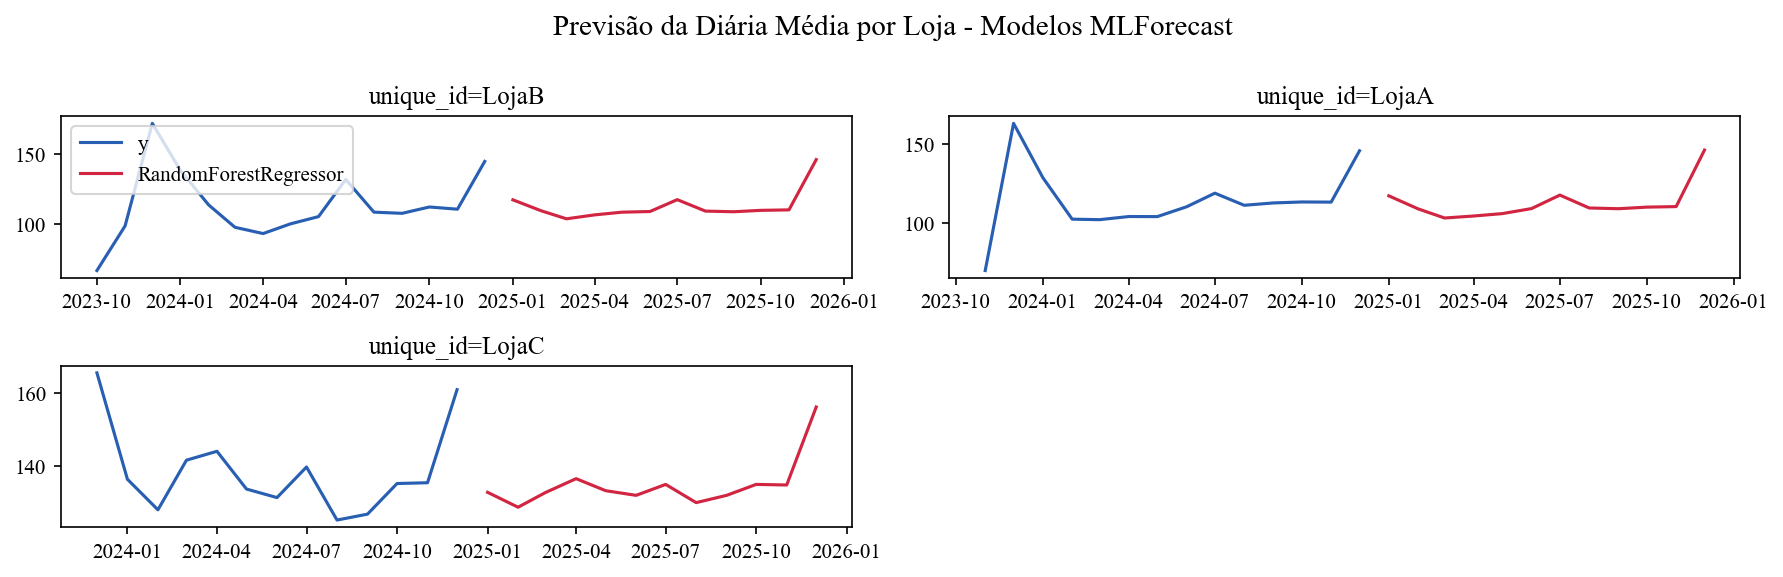

In [25]:
plot_time_series(
    df=pd.concat([diaria_media_df, predicted], ignore_index=True),
    data_cols=['y', 'RandomForestRegressor'],
    time_col='ds',
    id_col='unique_id',
    title='Previsão da Diária Média por Loja - Modelos MLForecast',
).show()

In [26]:
lasso_fitted_model = fcst.models_['LassoCV']
features_betas = pd.DataFrame(
    {
        'Feature': lasso_fitted_model.feature_names_in_,
        'Beta': lasso_fitted_model.coef_
    }
)
features_betas.sort_values(by='Beta', key=abs, ascending=False)

,Feature,Beta
11,mes_12,37.18
12,lag1,0.31
6,mes_7,0.18
13,expanding_mean_lag1,0.09
0,feriados,0.00
1,mes_2,-0.00
5,mes_6,-0.00
4,mes_5,-0.00
3,mes_4,-0.00
2,mes_3,-0.00


#### **_Comentários sobre a previsão de Diária Média._**
1. O modelo `RandomForest` apresentou maior acuracidade na validação cruzada, sendo mais recomendável para utilização da previsão dos meses futuros.
2. Para interpretação das variáveis, utilizaremos os coeficientes gerados pela regressão Lasso: As variáveis que tiveram mais impacto foram: mes_12 (dezembro) e mes_7 (julho); lag1; e expanding_mean_lag1.

**_Recomendações de Negócio:_**
- O mês de dezembro apresenta maior ticket médio comparado aos demais meses. Aproximadamente R$37 a mais que a média, provavelmente por se tratar de um período de férias, festas etc, as pessoas estão mais propensas a pagar valores um pouco mais altos por diárias. Além de que a demanda em outras locadoras aumenta, fazendo com que a oferta esteja mais escassa, logo o preço aumenta. Pode-se abordar estratégias de marketing voltado para esse período, buscando captação maior de clientes e consequentemente aumentando a margem e faturamento da empresa. Outro ponto é buscar meios de manter a frota com maior disponibilidade nesse período, evitando perda de clientes por falta de veículos, aproveitando ao máximo o _período ótimo_ financeiramente falando.
O mês de julho, que também teve coeficiente signifivativo, apresentou ticket médio apenas R$ 0,18 acima, o que não traz impacto para o negócio.

- lag1 indica um leve aumento de preços médios no cenário de curto prazo. Ou seja, aumentos de preços tendem a se extender por mais ou período. Nesse caso, forçar minimamente o preço após períodos de alta talvez seja uma estratégia viável para melhorar os indicadores de receita.

- expanding_mean_lag1 com $\hat{\beta}$ = 0.09 significa que 9% do preço médio histórico incorpora do preço atual. Isso sinaliza uma leve tendência de crescimento nos preços no longo prazo, o que pode ser notado pelos gráficos das séries. Esse efeito pode ser sinal de ajustes de preço que ocorrem anualmente para corrigir inflação e adequar os preços às estratégias do pricing.

- feriados: Apesar da não significância estatística da variável feriados, isso não exclui o fato de haver diferença estatísticamente significativa nos preços médios de reservas realizadas entre datas com e sem feriado. 
A não importância no modelo pode ser decorrente do fato de ter sido agregado em mês, mas se considerada a demanda diária, o fato de determinada data ser feriado ainda pode ter o impacto. Sendo assim, cabe uma análise adicional para avaliar o impacto do feriado no preço médio e posteriormente definir estratégias específicas para estes cenários.

#### **_Previsão da Quantidade de Diárias._**

In [27]:
qtd_diarias_df = (
    df_mensal
    .rename(columns={'id_loja':'unique_id', 'qtd_diarias_locadas':'y'})
    .drop(columns=['diaria_media'])
)
qtd_diarias_df.head()

,ds,unique_id,y,feriados,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,2023-10-01,LojaB,178,1,0,0,0,0,0,0,0,0,1,0,0
1,2023-11-01,LojaA,342,2,0,0,0,0,0,0,0,0,0,1,0
2,2023-11-01,LojaB,312,2,0,0,0,0,0,0,0,0,0,1,0
3,2023-12-01,LojaA,13412,1,0,0,0,0,0,0,0,0,0,0,1
4,2023-12-01,LojaB,7259,1,0,0,0,0,0,0,0,0,0,0,1


In [28]:
cv_df = fcst.cross_validation(
    df=qtd_diarias_df,
    h=1,
    n_windows=3,
    static_features=[]
)
cv_df.sort_values(by=['unique_id', 'ds'])

,unique_id,ds,cutoff,y,LassoCV,RandomForestRegressor
0,LojaA,2024-10-01,2024-09-01,30361,24230.19,27077.56
3,LojaA,2024-11-01,2024-10-01,29689,26155.54,29006.64
6,LojaA,2024-12-01,2024-11-01,35815,26362.28,29568.63
1,LojaB,2024-10-01,2024-09-01,11280,13175.34,10186.16
4,LojaB,2024-11-01,2024-10-01,12561,13697.37,8306.11
7,LojaB,2024-12-01,2024-11-01,18337,14424.93,21537.88
2,LojaC,2024-10-01,2024-09-01,7342,12069.04,8939.60
5,LojaC,2024-11-01,2024-10-01,7869,11126.21,7168.78
8,LojaC,2024-12-01,2024-11-01,15168,11154.84,8023.23


In [29]:
cv_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
cv_rmse

,metric,LassoCV,RandomForestRegressor
0,rmse,4485.10,3825.90


In [30]:
fcst.fit(qtd_diarias_df, static_features=[])
predicted = fcst.predict(h=12, X_df=future_df)

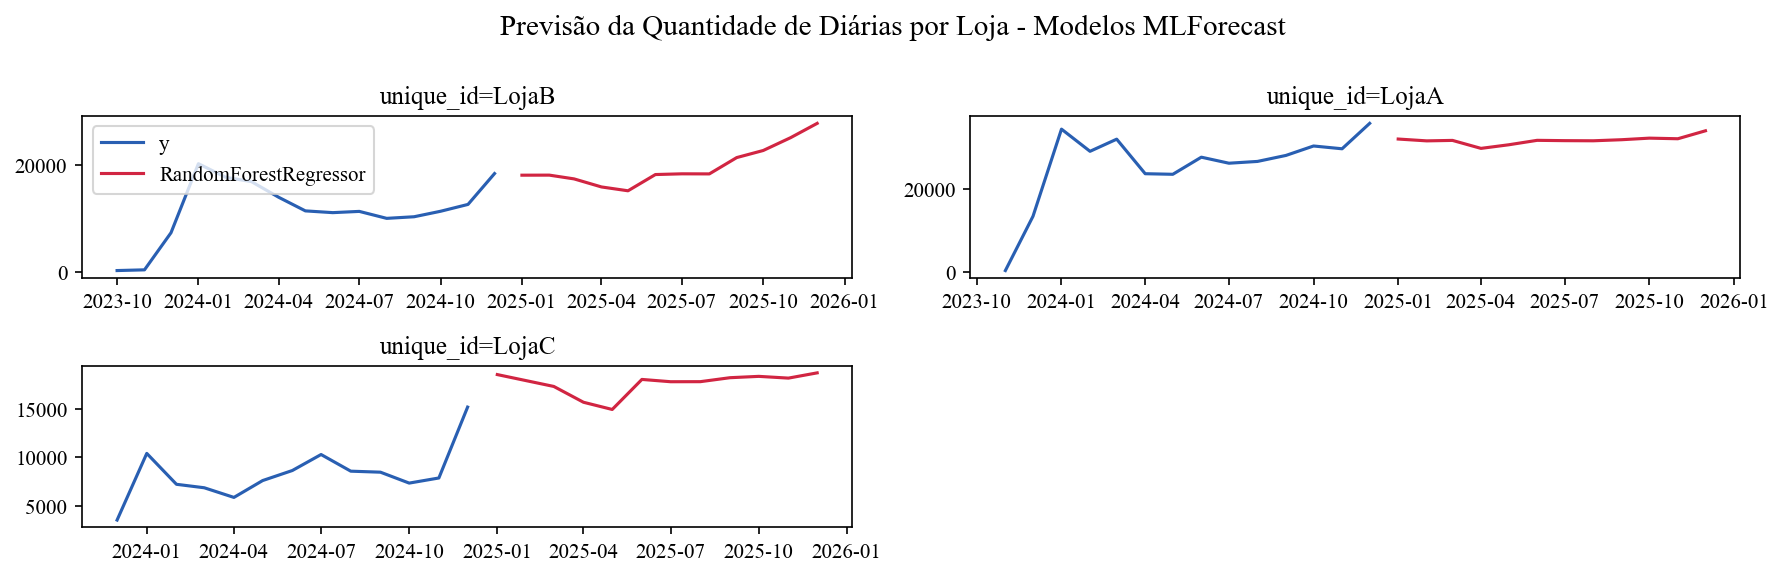

In [31]:
plot_time_series(
    df=pd.concat([qtd_diarias_df, predicted], ignore_index=True),
    data_cols=['y', 'RandomForestRegressor'],
    time_col='ds',
    id_col='unique_id',
    title='Previsão da Quantidade de Diárias por Loja - Modelos MLForecast',
).show()

In [32]:
lasso_fitted_model = fcst.models_['LassoCV']
features_betas = pd.DataFrame(
    {
        'Feature': lasso_fitted_model.feature_names_in_,
        'Beta': lasso_fitted_model.coef_
    }
)
features_betas.sort_values(by='Beta', key=abs, ascending=False)

,Feature,Beta
12,lag1,0.72
0,feriados,0.00
2,mes_3,-0.00
3,mes_4,-0.00
4,mes_5,-0.00
1,mes_2,-0.00
5,mes_6,-0.00
6,mes_7,-0.00
8,mes_9,-0.00
7,mes_8,-0.00


#### **_Comentários sobre a previsão de Quantidade de Diárias._**
1. O modelo `RandomForest` também apresentou maior acuracidade na validação cruzada, sendo mais recomendável para utilização da previsão dos meses futuros.
2. Interpretação das variáveis: Apenas a variável lag1 teve impacto significativo na previsão.

**_Recomendações de Negócio:_**
- Apenas uma das variáveis foi relevante para o contexto da previsão, o que pode indicar ausência de informações e necessidade de maior investigação do problema. 
O $\hat{\beta}$ = 0.72 sugere que o mês seguinte incorpora em média 72% do valor atual. No entanto, se olharmos o gráfico das séries, assim como a previsão, é notório que esse resultado não se sustenta em todos os casos, e pode haver uma elevação do valor devido à quebra estrutural da série que pode ter ocorrido entre o fim de 2023 e início de 2024, onde todas as séries apresentam crescimento acelerado e depois se sustenta. Embora seja verdade que exista uma leve tendência de crescimento, não é tão acentuada quanto 72%.
Cabe ao time de negócios investigar quais mudanças e estratégias foram implementadas nos períodos de maior variação positiva para tentar de alguma maneira replicar estes eventos e fomentar o crescimento do negócio. É possível que tenha ocorrido mudanças no mercado, como saída de um player relevante, ou inauguração de algum ponto turístico nas redondezas das lojas que atraiu mais clientes.
Caso se confirme uma mudança no cenário externo, deve-se buscar investir em campanhas direcionadas e tentar firmar parcerias com agências ou empresas que estejam envolvidas diretamente com os acontecimentos.
Caso seja uma mudança interna que ocasionou o crescimento, vale considerar replicar as estratégias e melhorá-las.